In [1]:
import pickle
import os
import argparse
import torch
from jax import random
import json
import datetime
from src.losses import sse_loss
from src.helper import calculate_exact_ggn, tree_random_normal_like
from src.sampling.predictive_samplers import sample_predictive, sample_hessian_predictive
from jax import numpy as jnp
import jax
from jax import flatten_util
import matplotlib.pyplot as plt
import tree_math as tm
from src.sampling.exact_ggn import exact_ggn_laplace
from src.sampling.laplace_ode import ode_ggn

In [2]:
def f(x):
    return jnp.sin(5 * x + 1) #+ jnp.cos(25 * x + 1) + jnp.exp(0.1 * x) + 5


In [3]:
param_dict = pickle.load(open("../checkpoints/syntetic_regression.pickle", "rb"))
params = param_dict['params']
alpha = param_dict['alpha']
rho = param_dict['rho']
x_train, y_train, x_val, y_val, model, D = param_dict["train_stats"]['x_train'],param_dict["train_stats"]['y_train'],param_dict["train_stats"]['x_val'],param_dict["train_stats"]['y_val'],param_dict["train_stats"]['model'], param_dict["train_stats"]['n_params']

In [24]:
params_vec, unflatten_fn = jax.flatten_util.ravel_pytree(params)
def model_apply_vec(params_vectorized, x):
        return model.apply(unflatten_fn(params_vectorized), x)

J = jax.jacfwd(lambda p: model_apply_vec(p, x_train))(params_vec)
J = J.squeeze()
GGN = J.T @ J

In [5]:
params_vec, unflatten_fn = jax.flatten_util.ravel_pytree(params)
def model_apply_vec(params_vectorized, x):
        return model.apply(unflatten_fn(params_vectorized), x)

J = jax.jacfwd(lambda p: model_apply_vec(p, x_train[0][None, ...]))(params_vec)
J = J.squeeze()
GGN_single = J.T @ J

In [6]:
leafs, tree_def = jax.tree_util.tree_flatten(params)
N_llla = len(leafs[-1]) + len(leafs[-2])

In [7]:
jnp.concatenate([jnp.ones(100), jnp.ones(11)]).shape

(111,)

In [8]:
def last_layer_model_fn(last_params_vec, first_params, x):
    first_params = jax.lax.stop_gradient(first_params)
    vectorized_params = jnp.concatenate([first_params, last_params_vec])
    return model_apply_vec(vectorized_params, x)


In [9]:
jnp.allclose(last_layer_model_fn(params_vec[-N_llla:], params_vec[:-N_llla], x_train), model_apply_vec(params_vec, x_train))


Array(True, dtype=bool)

In [10]:
params_ll = params_vec[-N_llla:]
J_ll = jax.jacfwd(last_layer_model_fn, argnums=0)(params_ll, params_vec[:-N_llla], x_train)
J_ll = J_ll.reshape(-1, N_llla)
GGN_ll = J_ll.T @ J_ll

In [18]:
x_train.shape

(50, 1)

In [22]:
J_ll.shape

(50, 11)

In [56]:
ggn_ll_true = GGN[-11:, -11:]

In [57]:
jnp.allclose(GGN_ll, ggn_ll_true)

Array(True, dtype=bool)

In [65]:
alpha = 1.
eigvals, eigvecs = jnp.linalg.eigh(GGN_ll + alpha * jnp.eye(GGN_ll.shape[0]))

In [66]:
eigvals

Array([  0.99999833,   1.0000008 ,   1.0000138 ,   1.0000212 ,
         1.0001522 ,   1.0004643 ,   1.1003485 ,   1.499156  ,
         3.828558  , 126.575356  , 142.13736   ], dtype=float32)

In [13]:
sample_key = jax.random.PRNGKey(100)
model_fn = lambda params, x: model.apply(params, x[None, ...])[0]
n_params = D 
rank = 3
alpha = 1.0
n_posterior_samples = 200
var = 0.1

lr_posterior_samples, posterior_samples, isotropic_posterior_samples = exact_ggn_laplace(sse_loss, 
                                                                                         model_fn,
                                                                                         params,
                                                                                         x_train,
                                                                                         y_train,
                                                                                         n_params,
                                                                                         rank,
                                                                                         alpha,
                                                                                         n_posterior_samples,
                                                                                         sample_key,
                                                                                         var,
                                                                                         "all"
                                                                                         )

In [47]:
diag = jnp.diag(GGN)
alpha = 50.
covariance = 1/jnp.sqrt(diag + alpha)
eps = jax.random.normal(random.PRNGKey(0), (n_posterior_samples, D,))
diag_samples = jax.vmap(lambda e: unflatten_fn(params_vec + covariance * e))(eps)


### Sparse

In [7]:
def layer1(params, x):
  return model.apply(params, x,
    method=lambda module, x: module.layer1(x))

def act1(params, x):
  return model.apply(params, x,
    method=lambda module, x: module.act1(x))


def layer2(params, x):
  return model.apply(params, x,
    method=lambda module, x: module.layer2(x))


In [8]:
model.apply(params, x_train)[:10]

Array([[-0.8916481 ],
       [ 0.7521084 ],
       [-0.9534399 ],
       [ 0.9836075 ],
       [ 0.8268783 ],
       [-0.9838969 ],
       [ 0.99649924],
       [ 0.94970787],
       [-0.9668674 ],
       [-0.9323314 ]], dtype=float32)

In [9]:
def l1(p):
    return layer1(p, x_train[:3])
def a1(p):
    z1 = l1(p)
    return act1(p, z1)

act = a1(params)



AttributeError: "FC_NN" object has no attribute "layer1".

In [ ]:
from jax.experimental import sparse

act = sparse.BCOO.fromdense(a1(params))

def l2(p):
    return layer2(p, act)

NameError: name 'a1' is not defined

In [10]:
jnp.allclose(l2(params), model.apply(params, x_train[:3]))

NameError: name 'l2' is not defined

In [11]:
print(jax.jacobian(l1)(params,)['params']['layer1']['bias'].shape)
print(jax.jacobian(l1)(params,)['params']['layer1']['kernel'].shape)
print(jax.jacobian(l1)(params,)['params']['layer2']['bias'].shape)
print(jax.jacobian(l1)(params,)['params']['layer2']['kernel'].shape)

AttributeError: "FC_NN" object has no attribute "layer1".

In [12]:
jacobian_tree = jax.jacobian(l1)(params,)
db1 = jax.tree_util.tree_flatten(jacobian_tree)[0][0][0]
dw1 = jax.tree_util.tree_flatten(jacobian_tree)[0][1][0].squeeze()

AttributeError: "FC_NN" object has no attribute "layer1".

In [17]:
jnp.diag(db1)

Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],      dtype=float32)

In [18]:
jnp.diag(dw1)

Array([0.65278494, 0.65278494, 0.65278494, 0.65278494, 0.65278494,
       0.65278494, 0.65278494, 0.65278494, 0.65278494, 0.65278494,
       0.65278494, 0.65278494, 0.65278494, 0.65278494, 0.65278494],      dtype=float32)

In [19]:
print(jax.jacobian(a1)(params,)['params']['layer1']['bias'].shape)
print(jax.jacobian(a1)(params,)['params']['layer1']['kernel'].shape)
print(jax.jacobian(a1)(params,)['params']['layer2']['bias'].shape)
print(jax.jacobian(a1)(params,)['params']['layer2']['kernel'].shape)

(3, 15, 15)
(3, 15, 1, 15)
(3, 15, 1)
(3, 15, 15, 1)


In [20]:
jacobian_tree = jax.jacobian(a1)(params,)

In [21]:
db1 = jax.tree_util.tree_flatten(jacobian_tree)[0][0][0]
dw1 = jax.tree_util.tree_flatten(jacobian_tree)[0][1][0].squeeze()
db2 = jax.tree_util.tree_flatten(jacobian_tree)[0][2][0].squeeze()
dw2 = jax.tree_util.tree_flatten(jacobian_tree)[0][3][0].squeeze()

In [22]:
jnp.diag(db1)

Array([0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0.],      dtype=float32)

In [23]:
jnp.diag(dw1)

Array([0.        , 0.65278494, 0.        , 0.65278494, 0.        ,
       0.65278494, 0.        , 0.65278494, 0.65278494, 0.65278494,
       0.65278494, 0.65278494, 0.        , 0.        , 0.        ],      dtype=float32)

In [24]:
db2

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)

In [25]:
print(jax.jacobian(l2)(params,)['params']['layer1']['bias'].shape)
print(jax.jacobian(l2)(params,)['params']['layer1']['kernel'].shape)
print(jax.jacobian(l2)(params,)['params']['layer2']['bias'].shape)
print(jax.jacobian(l2)(params,)['params']['layer2']['kernel'].shape)

(3, 1, 15)
(3, 1, 1, 15)
(3, 1, 1)
(3, 1, 15, 1)


In [26]:
jacobian_tree = jax.jacobian(l2)(params,)
db1 = jax.tree_util.tree_flatten(jacobian_tree)[0][0][0]
dw1 = jax.tree_util.tree_flatten(jacobian_tree)[0][1][0].squeeze()
db2 = jax.tree_util.tree_flatten(jacobian_tree)[0][2][0].squeeze()
dw2 = jax.tree_util.tree_flatten(jacobian_tree)[0][3][0].squeeze()

In [27]:
db1

Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],      dtype=float32)

In [28]:
dw1

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)

In [31]:
db2

Array(1., dtype=float32)

In [32]:
dw2

Array([0.        , 0.3821476 , 0.        , 0.5442997 , 0.        ,
       0.6443651 , 0.        , 0.76349056, 0.5066987 , 0.26094615,
       0.3343199 , 0.39402175, 0.        , 0.        , 0.        ],      dtype=float32)

In [33]:
a1(params)[0]

Array([0.        , 0.3821476 , 0.        , 0.5442997 , 0.        ,
       0.6443651 , 0.        , 0.76349056, 0.5066987 , 0.26094615,
       0.3343199 , 0.39402175, 0.        , 0.        , 0.        ],      dtype=float32)

In [34]:
true_jacobian_tree = jax.jacobian(lambda p: model.apply(p, x_train[:3]))(params,)
true_jacobian_tree = jax.tree_util.tree_flatten(true_jacobian_tree)[0]
true_jacobian_tree = list(map(jnp.squeeze, true_jacobian_tree))

# true_jacobian_tree = list(map(lambda a: jnp.expand_dims(a, axis=1), true_jacobian_tree))
# true_jacobian = jnp.concatenate(true_jacobian_tree, axis=0)

In [35]:
print(db1)
print(true_jacobian_tree[0][0])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[ 0.         -0.6807932   0.         -0.29579738  0.         -0.3554454
  0.         -0.07400993  0.20689346 -0.35551232 -0.5676495   0.48750222
  0.          0.          0.        ]


In [36]:
print(dw1)
print(true_jacobian_tree[1][0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.         -0.44441158  0.         -0.19309208  0.         -0.23202941
  0.         -0.04831257  0.13505693 -0.23207308 -0.37055305  0.31823412
  0.          0.          0.        ]


In [152]:
sparse.BCOO.fromdense(dw2)

BCOO(float32[15], nse=8)

In [10]:
params

{'params': {'Dense_0': {'bias': Array([ 0.2765854 , -0.6024642 ,  0.33561516, -0.19108233,  0.5592637 ,
          -0.7921506 ,  0.18739153,  0.67726195,  0.324081  ,  0.59314597],      dtype=float32),
   'kernel': Array([[ 0.5663058 ,  0.91286516, -0.5876289 ,  1.584447  ,  0.5714348 ,
            1.0649154 ,  0.5649579 , -0.9125132 , -0.8862641 , -1.6157333 ]],      dtype=float32)},
  'Dense_1': {'bias': Array([-0.02844273,  0.32567576,  0.0623464 ,  0.01216763,  0.04550786,
          -0.0887953 ,  0.30467987, -0.55933714,  0.13944589,  0.09904373],      dtype=float32),
   'kernel': Array([[-3.87254030e-01,  1.50593549e-01, -1.38083756e-01,
           -3.55425924e-02, -2.74130492e-03,  1.81467474e-01,
           -4.74106893e-03, -8.12219024e-01,  1.81623220e-01,
           -7.91248679e-02],
          [-4.65009809e-01, -8.66106987e-01, -6.80261075e-01,
            2.56109387e-01, -2.21026555e-01,  4.48103875e-01,
           -8.18484724e-01, -3.41923863e-01, -6.87635317e-02,
           

In [11]:
y, state = model.apply(params, x_train, capture_intermediates=True, mutable=["intermediates"])


In [13]:
state['intermediates'].keys()

dict_keys(['Dense_0', 'Dense_1', 'Dense_2', '__call__'])

## Sampled Laplace

In [69]:
predictive = sample_predictive(posterior_samples, params, model.apply, x_val, False, "Pytree")

lin_predictive = sample_predictive(posterior_samples, params, model.apply, x_val, True, "Pytree")
# predictive = sample_hessian_predictive(posterior_samples, model.apply, params, x_val)

In [70]:
posterior_predictive_mean = jnp.mean(predictive, axis=0).squeeze()
posterior_predictive_std = jnp.std(predictive, axis=0).squeeze()
preds = model.apply(params, x_val)
x_sorted, idx = jnp.sort(x_val[:, 0]), jnp.argsort(x_val[:, 0])
preds_sorted = preds[idx][:, 0]
means_sorted = posterior_predictive_mean[idx]
samples_sorted = predictive[:, idx, :].squeeze()
std_sorted = posterior_predictive_std[idx]


lin_posterior_predictive_mean = jnp.mean(lin_predictive, axis=0).squeeze()
lin_posterior_predictive_std = jnp.std(lin_predictive, axis=0).squeeze()
preds = model.apply(params, x_val)
x_sorted, idx = jnp.sort(x_val[:, 0]), jnp.argsort(x_val[:, 0])
preds_sorted = preds[idx][:, 0]
lin_means_sorted = lin_posterior_predictive_mean[idx]
lin_samples_sorted = lin_predictive[:, idx, :].squeeze()
lin_std_sorted = lin_posterior_predictive_std[idx]


In [71]:
diag_predictive = sample_predictive(diag_samples, params, model.apply, x_val, False, "Pytree")

lin_diag_predictive = sample_predictive(diag_samples, params, model.apply, x_val, True, "Pytree")



In [72]:
diag_posterior_predictive_mean = jnp.mean(diag_predictive, axis=0).squeeze()
diag_posterior_predictive_std = jnp.std(diag_predictive, axis=0).squeeze()
preds = model.apply(params, x_val)
x_sorted, idx = jnp.sort(x_val[:, 0]), jnp.argsort(x_val[:, 0])
preds_sorted = preds[idx][:, 0]
diag_means_sorted = diag_posterior_predictive_mean[idx]
samples_sorted = predictive[:, idx, :].squeeze()
diag_std_sorted = diag_posterior_predictive_std[idx]


lin_diag_posterior_predictive_mean = jnp.mean(lin_diag_predictive, axis=0).squeeze()
lin_diag_posterior_predictive_std = jnp.std(lin_diag_predictive, axis=0).squeeze()
preds = model.apply(params, x_val)
x_sorted, idx = jnp.sort(x_val[:, 0]), jnp.argsort(x_val[:, 0])
preds_sorted = preds[idx][:, 0]
lin_diag_means_sorted = lin_diag_posterior_predictive_mean[idx]
lin_diag_samples_sorted = lin_diag_predictive[:, idx, :].squeeze()
lin_diag_std_sorted = lin_diag_posterior_predictive_std[idx]


In [52]:
posterior_predictive_mean = jnp.mean(predictive, axis=0).squeeze()
posterior_predictive_std = jnp.std(predictive, axis=0).squeeze()
preds = model.apply(params, x_val)
x_sorted, idx = jnp.sort(x_val[:, 0]), jnp.argsort(x_val[:, 0])
preds_sorted = preds[idx][:, 0]
means_sorted = posterior_predictive_mean[idx]
samples_sorted = predictive[:, idx, :].squeeze()
std_sorted = posterior_predictive_std[idx]


In [83]:
from tueplots import bundles
config_plt = bundles.neurips2023()
config_plt['text.usetex'] = False
plt.rcParams.update(config_plt)


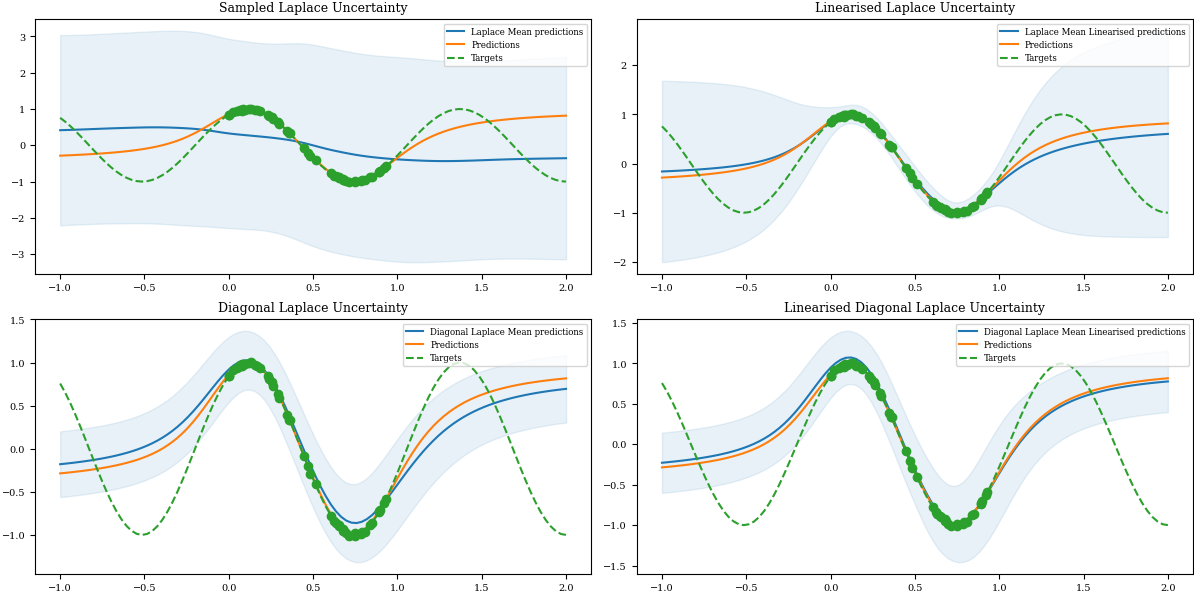

In [87]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

ax_1 = axes[0, 0]
line_1 = ax_1.plot(x_sorted, means_sorted, label="Laplace Mean predictions", marker="None")
ax_1.fill_between(
    x_sorted, means_sorted - std_sorted, means_sorted + std_sorted, alpha=0.1, color=line_1[0].get_color()
)

ax_1.plot(x_sorted, preds_sorted, label="Predictions", marker="None")
line = ax_1.plot(x_sorted, f(x_sorted), label="Targets", marker="None", linestyle="--")
ax_1.plot(
    jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), color=line[0].get_color(), linestyle="None", marker="o"
)
ax_1.legend(fontsize="x-small", loc="upper right")
ax_1.title.set_text("Sampled Laplace Uncertainty")

ax_2 = axes[0, 1]
line_2 = ax_2.plot(x_sorted, lin_means_sorted, label="Laplace Mean Linearised predictions", marker="None")
ax_2.fill_between(
    x_sorted, lin_means_sorted - lin_std_sorted, lin_means_sorted + lin_std_sorted, alpha=0.1, color=line_2[0].get_color()
)

ax_2.plot(x_sorted, preds_sorted, label="Predictions", marker="None")
line = ax_2.plot(x_sorted, f(x_sorted), label="Targets", marker="None", linestyle="--")
ax_2.plot(
    jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), color=line[0].get_color(), linestyle="None", marker="o"
)
ax_2.legend(fontsize="x-small", loc="upper right")
ax_2.title.set_text("Linearised Laplace Uncertainty")

ax_3 = axes[1, 0]
line_3 = ax_3.plot(x_sorted, diag_means_sorted, label="Diagonal Laplace Mean predictions", marker="None")
ax_3.fill_between(
    x_sorted, diag_means_sorted - diag_std_sorted, diag_means_sorted + diag_std_sorted, alpha=0.1, color=line_3[0].get_color()
)

ax_3.plot(x_sorted, preds_sorted, label="Predictions", marker="None")
line = ax_3.plot(x_sorted, f(x_sorted), label="Targets", marker="None", linestyle="--")
ax_3.plot(
    jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), color=line[0].get_color(), linestyle="None", marker="o"
)
ax_3.legend(fontsize="x-small", loc="upper right")
ax_3.title.set_text("Diagonal Laplace Uncertainty")

ax_4 = axes[1, 1]
line_4 = ax_4.plot(x_sorted, lin_diag_means_sorted, label="Diagonal Laplace Mean Linearised predictions", marker="None")
ax_4.fill_between(
    x_sorted, lin_diag_means_sorted - lin_diag_std_sorted, lin_diag_means_sorted + lin_diag_std_sorted, alpha=0.1, color=line_3[0].get_color()
)

ax_4.plot(x_sorted, preds_sorted, label="Predictions", marker="None")
line = ax_4.plot(x_sorted, f(x_sorted), label="Targets", marker="None", linestyle="--")
ax_4.plot(
    jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), color=line[0].get_color(), linestyle="None", marker="o"
)
ax_4.legend(fontsize="x-small", loc="upper right")
ax_4.title.set_text("Linearised Diagonal Laplace Uncertainty")


plt.savefig(f"./uncertainty_diag_full.pdf")


## Laplace Diffusion

### Proj VP

In [18]:
output_dim = 1
def nonker_proj_vp(v, model_fn, params, X):
    lmbd = lambda p: model_fn(p, X)
    _, jtv_fn = jax.vjp(lmbd, params)
    def kvp(v_):
        _, jtv_fn = jax.vjp(lmbd, params)
        Jtv = jtv_fn(v_.reshape((X.shape[0],output_dim)))[0]
        _, JJtv = jax.jvp(lmbd, (params,), (Jtv,))
        return JJtv
    JJt = jax.jacfwd(kvp)(jnp.ones((X.shape[0], output_dim,)))
    JJt = JJt.reshape(X.shape[0] * output_dim, X.shape[0] * output_dim)
    _, Jv = jax.jvp(lmbd, (params,), (v,))
    JJt_inv_Jv = jnp.linalg.lstsq(JJt, Jv.reshape(-1))[0]
    _, jtv_fn = jax.vjp(lmbd, params)
    JJt_inv_Jv = JJt_inv_Jv.reshape((X.shape[0],output_dim))
    Jt_JJt_inv_Jv = jtv_fn(JJt_inv_Jv)[0]
    return Jt_JJt_inv_Jv

def ker_proj_vp(v, model_fn, params, X):
    lmbd = lambda p: model_fn(p, X)
    _, jtv_fn = jax.vjp(lmbd, params)
    def kvp(v_):
        _, jtv_fn = jax.vjp(lmbd, params)
        Jtv = jtv_fn(v_.reshape((X.shape[0],output_dim)))[0]
        _, JJtv = jax.jvp(lmbd, (params,), (Jtv,))
        return JJtv
    JJt = jax.jacfwd(kvp)(jnp.ones((X.shape[0], output_dim,)))
    JJt = JJt.reshape(X.shape[0] * output_dim, X.shape[0] * output_dim)
    _, Jv = jax.jvp(lmbd, (params,), (v,))
    JJt_inv_Jv = jnp.linalg.lstsq(JJt, Jv.reshape(-1))[0]
    _, jtv_fn = jax.vjp(lmbd, params)
    JJt_inv_Jv = JJt_inv_Jv.reshape((X.shape[0],output_dim))
    Jt_JJt_inv_Jv = jtv_fn(JJt_inv_Jv)[0]
    return (tm.Vector(v) - tm.Vector(Jt_JJt_inv_Jv)).tree

In [29]:
n_steps = 1000
n_samples = 50
eps = tree_random_normal_like(sample_key, params, n_samples)
alpha = 1.0
rank = 7
p0_flat, unravel_func_p = jax.flatten_util.ravel_pytree(params)
# rank = 100
# alpha = 0.1
key_list = jax.random.split(jax.random.PRNGKey(10), n_steps)
key = jax.random.PRNGKey(10)
@jax.jit
def rw_nonker(key):
    params_ = params
    sample_key, split_key = jax.random.split(key)
    eps = tree_random_normal_like(sample_key, params, n_samples)
    # posterior_list = [params]
    def body_fun(n, res):
        # split_key = key_list[n]
        # sample_key, split_key = jax.random.split(split_key)
        sample_key = key_list[n]
        eps = tree_random_normal_like(sample_key, params, n_samples)
        lr_samples = jax.vmap(nonker_proj_vp, in_axes=(0,None,None,None))(eps, model.apply, params, x_train)
        params_ = jax.tree_map(lambda x,y: x + 1/jnp.sqrt(n_steps) * 1/jnp.sqrt(alpha) * y, res, lr_samples)
        # posterior_list.append(params_)
        return params_
    v_ = jax.lax.fori_loop(0, n_steps - 1, body_fun, jax.tree_map(lambda x: jnp.array(n_samples*[x]), params))
    return v_
nonker_posterior_samples = rw_nonker(key)

#     for i in range(n_steps):
#         sample_key, split_key = jax.random.split(split_key)
#         eps = tree_random_normal_like(sample_key, params, n_samples)
#         lr_samples = jax.vmap(nonker_proj_vp, in_axes=(0,None,None,None))(eps, model.apply, params, x_train)
#         params_ = jax.tree_map(lambda x,y: x + 1/jnp.sqrt(n_steps) * 1/jnp.sqrt(alpha) * y, params_, lr_samples)
#         posterior_list.append(params_)
#     return posterior_list
#     # return unravel_func_p(params_)

# nonker_posterior_samples = rw_nonker(key)[-1]#jax.vmap(rw_nonker)(eps)[-1]#jax.lax.map(rw, eps)

In [30]:
n_steps = 1000
n_samples = 50
eps = tree_random_normal_like(sample_key, params, n_samples)
alpha = 1.0
rank = 7
p0_flat, unravel_func_p = jax.flatten_util.ravel_pytree(params)
# rank = 100
# alpha = 0.1
key_list = jax.random.split(jax.random.PRNGKey(10), n_steps)
key = jax.random.PRNGKey(10)
@jax.jit
def rw_ker(key):
    params_ = params
    sample_key, split_key = jax.random.split(key)
    eps = tree_random_normal_like(sample_key, params, n_samples)
    # posterior_list = [params]
    def body_fun(n, res):
        # split_key = key_list[n]
        # sample_key, split_key = jax.random.split(split_key)
        sample_key = key_list[n]
        eps = tree_random_normal_like(sample_key, params, n_samples)
        lr_samples = jax.vmap(ker_proj_vp, in_axes=(0,None,None,None))(eps, model.apply, params, x_train)
        params_ = jax.tree_map(lambda x,y: x + 1/jnp.sqrt(n_steps) * 1/jnp.sqrt(alpha) * y, res, lr_samples)
        # posterior_list.append(params_)
        return params_
    v_ = jax.lax.fori_loop(0, n_steps - 1, body_fun, jax.tree_map(lambda x: jnp.array(n_samples*[x]), params))
    return v_
ker_posterior_samples = rw_ker(key)


In [31]:
# n_steps = 20
# n_samples = 50
# eps = tree_random_normal_like(sample_key, params, n_samples)
# alpha = 10.0
# rank = 7
# p0_flat, unravel_func_p = jax.flatten_util.ravel_pytree(params)
# # rank = 100
# # alpha = 0.1
# key = jax.random.PRNGKey(10)

# @jax.jit
# def rw_ker(key):
#     params_ = params
#     sample_key, split_key = jax.random.split(key)
#     eps = tree_random_normal_like(sample_key, params, n_samples)
#     posterior_list = [params]
#     for i in range(n_steps):
#         sample_key, split_key = jax.random.split(split_key)
#         eps = tree_random_normal_like(sample_key, params, n_samples)
#         lr_samples = jax.vmap(ker_proj_vp, in_axes=(0,None,None,None))(eps, model.apply, params, x_train)
#         params_ = jax.tree_map(lambda x,y: x + 1/jnp.sqrt(n_steps) * 1/jnp.sqrt(alpha) * y, params_, lr_samples)
#         posterior_list.append(params_)
#     return posterior_list
#     # return unravel_func_p(params_)

# ker_posterior_samples = rw_ker(key)[-1]#jax.vmap(rw_ker, in_axes=(0))(eps)[-1]#jax.lax.map(rw, eps)

In [35]:
# x_val = x_train
preds = model.apply(params, x_val)

ker_predictive = sample_predictive(ker_posterior_samples, params, model.apply, x_val, True, "Pytree")
# ker_posterior_predictive_mean = jnp.mean(ker_predictive, axis=0)
# ker_predictive = ker_predictive + preds - ker_posterior_predictive_mean
nonker_predictive = sample_predictive(nonker_posterior_samples, params, model.apply, x_val, True, "Pytree")
ker_posterior_predictive_mean = jnp.mean(ker_predictive, axis=0).squeeze()
ker_posterior_predictive_std = jnp.std(ker_predictive, axis=0).squeeze()
nonker_posterior_predictive_mean = jnp.mean(nonker_predictive, axis=0).squeeze()
nonker_posterior_predictive_std = jnp.std(nonker_predictive, axis=0).squeeze()


x_sorted, idx = jnp.sort(x_val[:, 0]), jnp.argsort(x_val[:, 0])
preds_sorted = preds[idx][:, 0]
ker_means_sorted = ker_posterior_predictive_mean[idx]
nonker_means_sorted = nonker_posterior_predictive_mean[idx]
ker_samples_sorted = ker_predictive[:, idx, :].squeeze()
nonker_samples_sorted = nonker_predictive[:, idx, :].squeeze()
ker_std_sorted = ker_posterior_predictive_std[idx]
nonker_std_sorted = nonker_posterior_predictive_std[idx]



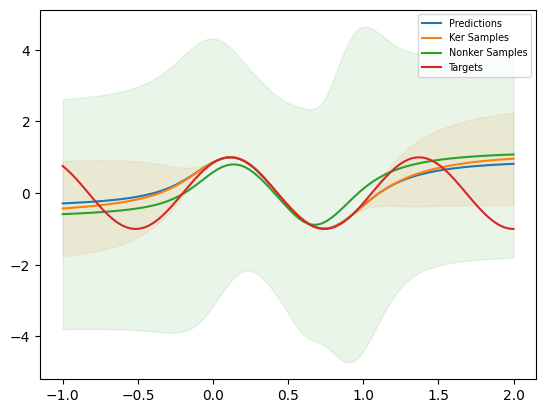

In [36]:
plt.plot(x_sorted, preds_sorted, label="Predictions", marker="None")
line = plt.plot(x_sorted, ker_means_sorted, label="Ker Samples", marker="None")
plt.fill_between(
    x_sorted, ker_means_sorted - ker_std_sorted, ker_means_sorted + ker_std_sorted, alpha=0.1, color=line[0].get_color()
)
line = plt.plot(x_sorted, nonker_means_sorted, label="Nonker Samples", marker="None")
plt.fill_between(
    x_sorted, nonker_means_sorted - nonker_std_sorted, nonker_means_sorted + nonker_std_sorted, alpha=0.1, color=line[0].get_color()
)

line = plt.plot(x_sorted, f(x_sorted), label="Targets", marker="None")
# plt.plot(
#     jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), color=line[0].get_color(), linestyle="None", marker="o"
# )
plt.legend(fontsize="x-small", loc="upper right")

plt.show()

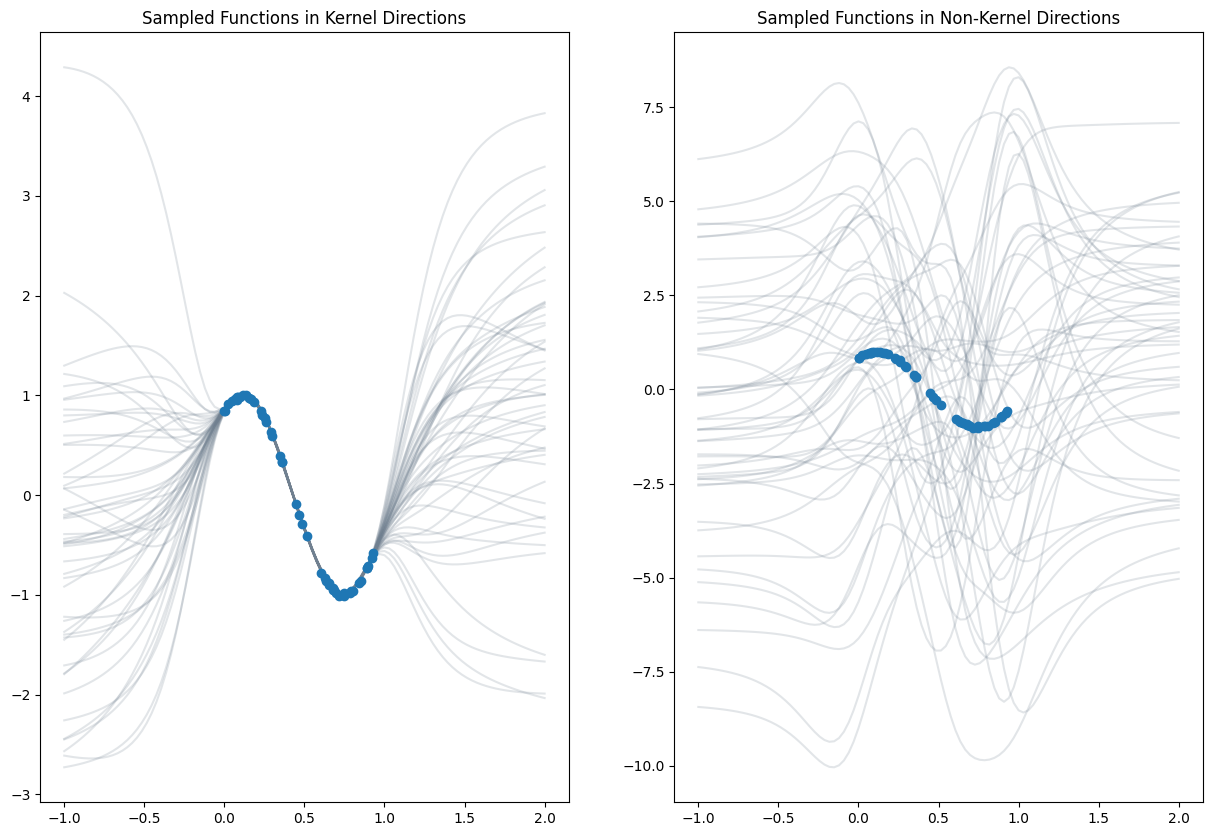

In [37]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 10))
ax[0].plot(x_sorted, ker_samples_sorted.transpose(), marker="None", linestyle="-", alpha=0.2, color="slategrey")
ax[0].plot(jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), label="Targets", linestyle="None", marker="o")
ax[0].set_title("Sampled Functions in Kernel Directions")
ax[1].plot(x_sorted, nonker_samples_sorted.transpose(), marker="None", linestyle="-", alpha=0.2, color="slategrey")
ax[1].plot(jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), label="Targets", linestyle="None", marker="o")
ax[1].set_title("Sampled Functions in Non-Kernel Directions")
plt.show()

### Explicit Matrix Computations

In [8]:
from src.sampling.exact_ggn_diffusion import exact_nonkernel_diffusion, exact_kernel_diffusion

In [9]:
_model_fn = lambda params, x: model.apply(params, x[None, ...])[0]

In [91]:
n_steps = 200
n_samples = 50
# alpha = 5.0
alpha = 10.0
rank = 7
sample_key = jax.random.PRNGKey(0)
nonker_posterior_samples = exact_nonkernel_diffusion(sse_loss, _model_fn, params, n_steps, n_samples,alpha, sample_key, D, rank, x_train, y_train)

In [115]:
n_steps = 200
n_samples = 50
# alpha = 5.0
alpha = 10.0
rank = 20
sample_key = jax.random.PRNGKey(0)
ker_posterior_samples = exact_kernel_diffusion(sse_loss, _model_fn, params, n_steps, n_samples,alpha, sample_key, D, rank, x_train, y_train)

In [125]:
jnp.std(ker_posterior_samples['params']['Dense_2']['bias'])

Array(0.15721473, dtype=float32)

In [117]:
jnp.mean(jnp.array(n_samples*[params['params']['Dense_2']['bias']]))

Array(0.26397395, dtype=float32)

In [110]:
ker_posterior_samples['params']['Dense_2']['bias'] = jnp.array(n_samples*[params['params']['Dense_2']['bias']])

In [111]:
x_val = x_train
ker_predictive = sample_predictive(ker_posterior_samples, params, model, x_val, False, "Pytree")
nonker_predictive = sample_predictive(nonker_posterior_samples, params, model, x_val, False, "Pytree")
ker_posterior_predictive_mean = jnp.mean(ker_predictive, axis=0).squeeze()
ker_posterior_predictive_std = jnp.std(ker_predictive, axis=0).squeeze()
nonker_posterior_predictive_mean = jnp.mean(nonker_predictive, axis=0).squeeze()
nonker_posterior_predictive_std = jnp.std(nonker_predictive, axis=0).squeeze()
preds = model.apply(params, x_val)


x_sorted, idx = jnp.sort(x_val[:, 0]), jnp.argsort(x_val[:, 0])
preds_sorted = preds[idx][:, 0]
ker_means_sorted = ker_posterior_predictive_mean[idx]
nonker_means_sorted = nonker_posterior_predictive_mean[idx]
ker_samples_sorted = ker_predictive[:, idx, :].squeeze()
nonker_samples_sorted = nonker_predictive[:, idx, :].squeeze()
ker_std_sorted = ker_posterior_predictive_std[idx]
nonker_std_sorted = nonker_posterior_predictive_std[idx]



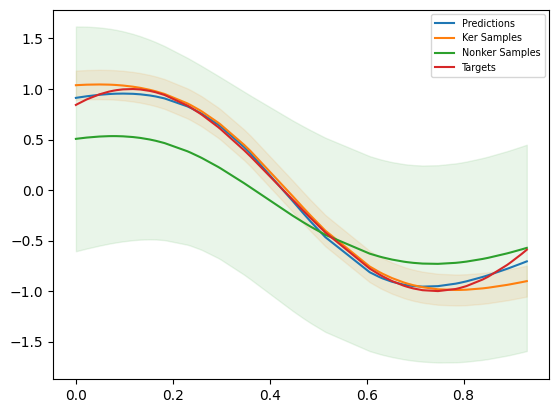

In [112]:
plt.plot(x_sorted, preds_sorted, label="Predictions", marker="None")
line = plt.plot(x_sorted, ker_means_sorted, label="Ker Samples", marker="None")
plt.fill_between(
    x_sorted, ker_means_sorted - ker_std_sorted, ker_means_sorted + ker_std_sorted, alpha=0.1, color=line[0].get_color()
)
line = plt.plot(x_sorted, nonker_means_sorted, label="Nonker Samples", marker="None")
plt.fill_between(
    x_sorted, nonker_means_sorted - nonker_std_sorted, nonker_means_sorted + nonker_std_sorted, alpha=0.1, color=line[0].get_color()
)

line = plt.plot(x_sorted, f(x_sorted), label="Targets", marker="None")
# plt.plot(
#     jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), color=line[0].get_color(), linestyle="None", marker="o"
# )
plt.legend(fontsize="x-small", loc="upper right")

plt.show()

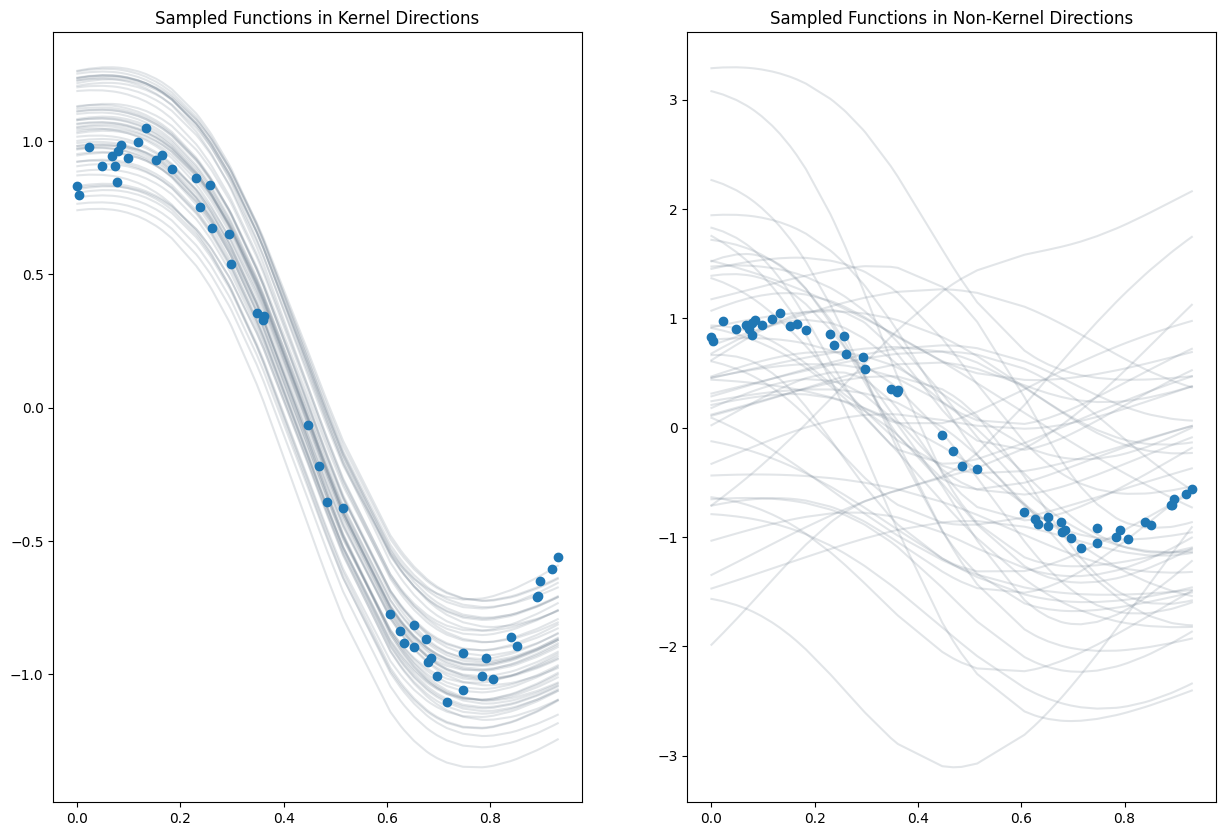

In [113]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 10))
ax[0].plot(x_sorted, ker_samples_sorted.transpose(), marker="None", linestyle="-", alpha=0.2, color="slategrey")
ax[0].plot(jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), label="Targets", linestyle="None", marker="o")
ax[0].set_title("Sampled Functions in Kernel Directions")
ax[1].plot(x_sorted, nonker_samples_sorted.transpose(), marker="None", linestyle="-", alpha=0.2, color="slategrey")
ax[1].plot(jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), label="Targets", linestyle="None", marker="o")
ax[1].set_title("Sampled Functions in Non-Kernel Directions")
plt.show()

## Lanczos Diffusion

In [8]:
sample_key = jax.random.PRNGKey(50)

In [10]:
from src.sampling.lanczos_diffusion import lanczos_diffusion
n_steps = 2000
n_samples = 50
alpha = 20.0
rank = 7
n_params = D
# nonker_posterior_samples = lanczos_diffusion(sse_loss, model.apply, params,n_steps,n_samples,alpha,sample_key,n_params,rank,x_train,y_train,1.0,"non-kernel")
nonker_posterior_samples = lanczos_diffusion(model, params,n_steps,n_samples,alpha,sample_key,n_params,rank,x_train,"regression",1.0,"non-kernel")

In [11]:
rank = 7

# ker_posterior_samples = lanczos_diffusion(sse_loss, model.apply, params,n_steps,n_samples,alpha,sample_key,n_params,rank,x_train,y_train,1.0,"kernel")
ker_posterior_samples = lanczos_diffusion(model, params,n_steps,n_samples,alpha,sample_key,n_params,rank,x_train,"regression",1.0,"kernel")

In [14]:
# x_val = x_train
x_val = jnp.linspace(-1,2,100).reshape(-1,1)
ker_predictive = sample_predictive(ker_posterior_samples, params, model.apply, x_val, False, "Pytree")
nonker_predictive = sample_predictive(nonker_posterior_samples, params, model.apply, x_val, False, "Pytree")
ker_posterior_predictive_mean = jnp.mean(ker_predictive, axis=0).squeeze()
ker_posterior_predictive_std = jnp.std(ker_predictive, axis=0).squeeze()
nonker_posterior_predictive_mean = jnp.mean(nonker_predictive, axis=0).squeeze()
nonker_posterior_predictive_std = jnp.std(nonker_predictive, axis=0).squeeze()
preds = model.apply(params, x_val)


x_sorted, idx = jnp.sort(x_val[:, 0]), jnp.argsort(x_val[:, 0])
preds_sorted = preds[idx][:, 0]
ker_means_sorted = ker_posterior_predictive_mean[idx]
nonker_means_sorted = nonker_posterior_predictive_mean[idx]
ker_samples_sorted = ker_predictive[:, idx, :].squeeze()
nonker_samples_sorted = nonker_predictive[:, idx, :].squeeze()
ker_std_sorted = ker_posterior_predictive_std[idx]
nonker_std_sorted = nonker_posterior_predictive_std[idx]



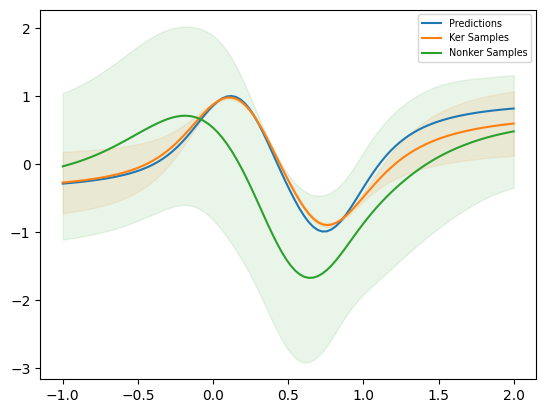

In [15]:
plt.plot(x_sorted, preds_sorted, label="Predictions", marker="None")
line = plt.plot(x_sorted, ker_means_sorted, label="Ker Samples", marker="None")
plt.fill_between(
    x_sorted, ker_means_sorted - ker_std_sorted, ker_means_sorted + ker_std_sorted, alpha=0.1, color=line[0].get_color()
)
line = plt.plot(x_sorted, nonker_means_sorted, label="Nonker Samples", marker="None")
plt.fill_between(
    x_sorted, nonker_means_sorted - nonker_std_sorted, nonker_means_sorted + nonker_std_sorted, alpha=0.1, color=line[0].get_color()
)

# line = plt.plot(x_sorted, f(x_sorted), label="Targets", marker="None")
# plt.plot(
#     jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), color=line[0].get_color(), linestyle="None", marker="o"
# )
plt.legend(fontsize="x-small", loc="upper right")

plt.show()

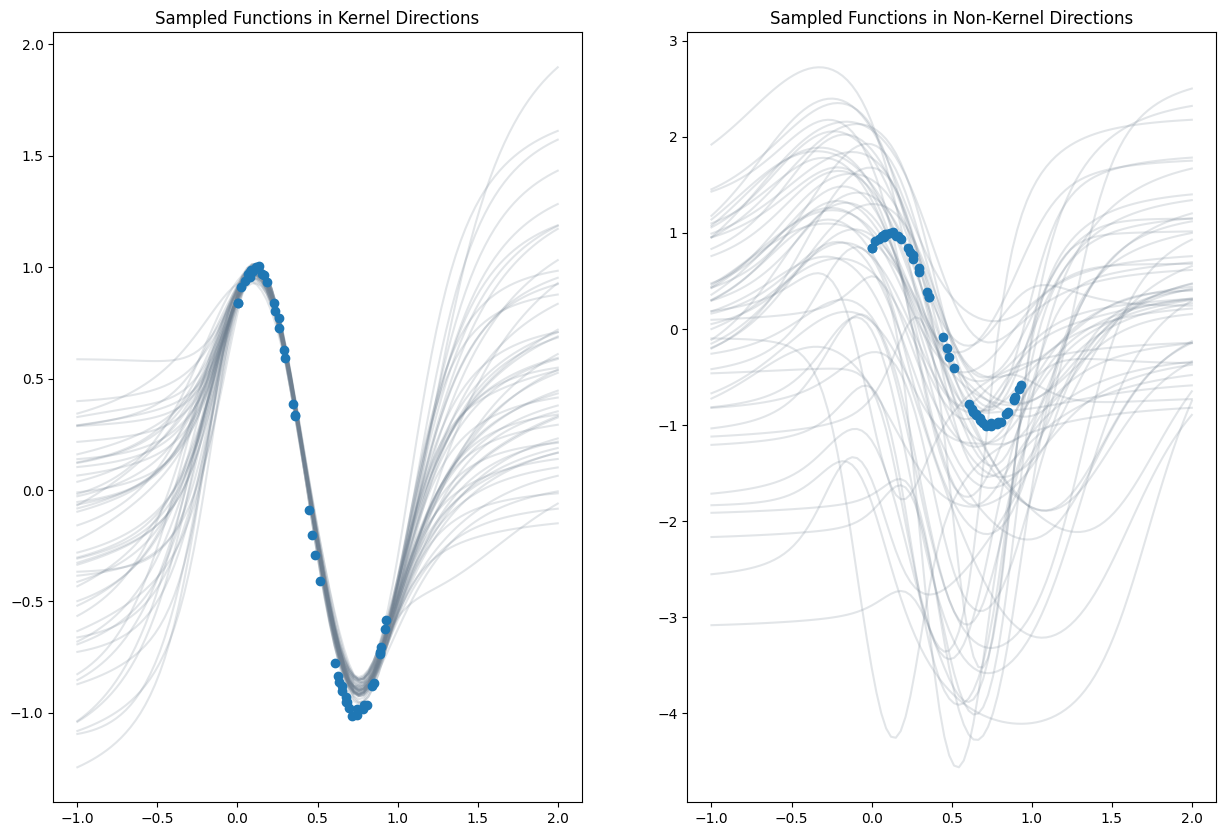

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 10))
ax[0].plot(x_sorted, ker_samples_sorted.transpose(), marker="None", linestyle="-", alpha=0.2, color="slategrey")
ax[0].plot(jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), label="Targets", linestyle="None", marker="o")
ax[0].set_title("Sampled Functions in Kernel Directions")
ax[1].plot(x_sorted, nonker_samples_sorted.transpose(), marker="None", linestyle="-", alpha=0.2, color="slategrey")
ax[1].plot(jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), label="Targets", linestyle="None", marker="o")
ax[1].set_title("Sampled Functions in Non-Kernel Directions")
plt.show()

## ODE Solver

### Kernel ODE

In [18]:
random_init_dir = jax.random.normal(sample_key, (D,))
v0 = jnp.ones(D)*5
n_evals = 10
integration_time = 1.0
rank = 7
ker_posterior, y_sols = ode_ggn(model,params,random_init_dir,v0,rank,n_evals,integration_time,x_train,"regression",1e-8, 1e-8,1.0,"kernel")


In [19]:
predictive = sample_predictive(ker_posterior, params, model, x_train, False, "Pytree")
posterior_predictive_mean = jnp.mean(predictive, axis=0).squeeze()
posterior_predictive_std = jnp.std(predictive, axis=0).squeeze()
preds = model.apply(params, x_train)
x_sorted, idx = jnp.sort(x_train[:, 0]), jnp.argsort(x_train[:, 0])
preds_sorted = preds[idx][:, 0]
means_sorted = posterior_predictive_mean[idx]
samples_sorted = predictive[:, idx, :].squeeze()
std_sorted = posterior_predictive_std[idx]


In [20]:
if n_evals==1:
    samples_sorted = jnp.expand_dims(samples_sorted, 0)

In [21]:
p0_flat, unravel_func_p = jax.flatten_util.ravel_pytree(params)

euclidean_distances = []
for param in y_sols:
    euclidean_distances.append(jnp.linalg.norm(param - p0_flat))
fn_space_distances = []
for fn in samples_sorted:
    fn_space_distances.append(jnp.linalg.norm(fn.squeeze() - preds_sorted))
    # fn_space_distances.append(jnp.linalg.norm(fn - preds_sorted))

In [22]:
fn_space_distances

[Array(0., dtype=float32),
 Array(0.03875258, dtype=float32),
 Array(0.07486077, dtype=float32),
 Array(0.13730699, dtype=float32),
 Array(0.16043894, dtype=float32),
 Array(0.19411647, dtype=float32),
 Array(0.18951407, dtype=float32),
 Array(0.1795768, dtype=float32),
 Array(0.20895, dtype=float32),
 Array(0.31158227, dtype=float32)]

In [23]:
euclidean_distances

[Array(0., dtype=float32),
 Array(1.2693911, dtype=float32),
 Array(2.5454428, dtype=float32),
 Array(3.8255496, dtype=float32),
 Array(5.0940785, dtype=float32),
 Array(6.3631783, dtype=float32),
 Array(7.6279526, dtype=float32),
 Array(8.897406, dtype=float32),
 Array(10.1715555, dtype=float32),
 Array(11.451783, dtype=float32)]

Text(0.5, 0, 'Euclidean Distance')

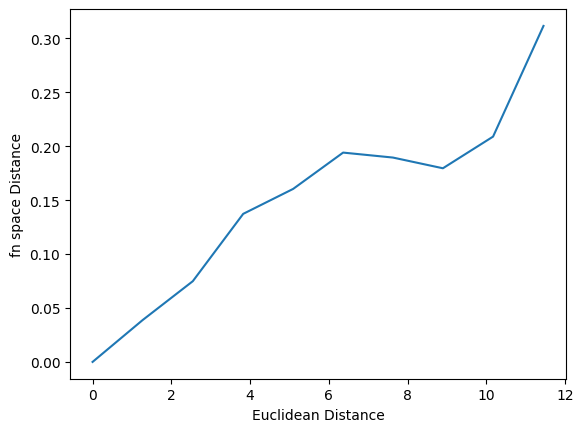

In [24]:
plt.plot(jnp.array(euclidean_distances), jnp.array(fn_space_distances))
plt.ylabel("fn space Distance")
plt.xlabel("Euclidean Distance")

Text(0.5, 1.0, 'Ode solutions')

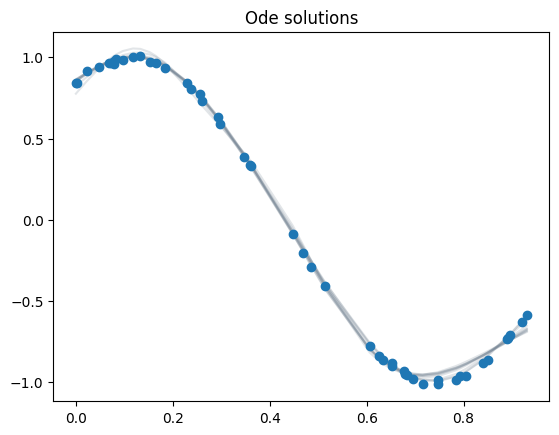

In [25]:
plt.plot(x_sorted, samples_sorted.transpose(), marker="None", linestyle="-", alpha=0.2, color="slategrey")
plt.plot(jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), label="Targets", linestyle="None", marker="o")
plt.title("Ode solutions")

### Non-Kernel ODE

In [26]:
random_init_dir = jax.random.normal(sample_key, (D,))
v0 = jnp.ones(D)*5
n_evals = 10
integration_time = 1.0
rank = 7
nonker_posterior, y_sols = ode_ggn(model,params,random_init_dir,v0,rank,n_evals,integration_time,x_train,"regression",1e-7, 1e-7,1.0,"non-kernel")


In [27]:
predictive = sample_predictive(nonker_posterior, params, model, x_train, False, "Pytree")
posterior_predictive_mean = jnp.mean(predictive, axis=0).squeeze()
posterior_predictive_std = jnp.std(predictive, axis=0).squeeze()
preds = model.apply(params, x_train)
x_sorted, idx = jnp.sort(x_train[:, 0]), jnp.argsort(x_train[:, 0])
preds_sorted = preds[idx][:, 0]
means_sorted = posterior_predictive_mean[idx]
samples_sorted = predictive[:, idx, :].squeeze()
std_sorted = posterior_predictive_std[idx]


In [28]:
euclidean_distances = []
for param in y_sols:
    euclidean_distances.append(jnp.linalg.norm(param - p0_flat))
fn_space_distances = []
for fn in samples_sorted:
    fn_space_distances.append(jnp.linalg.norm(fn.squeeze() - preds_sorted))

Text(0.5, 0, 'Euclidean Distance')

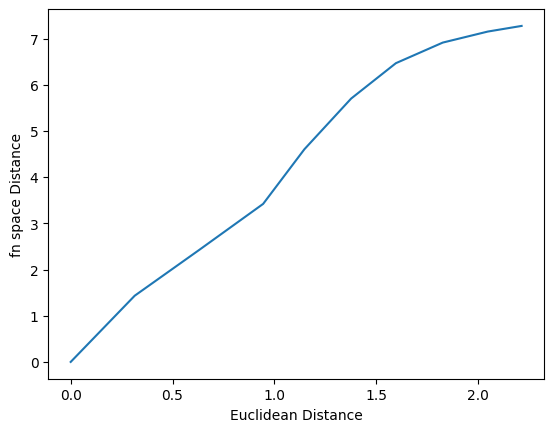

In [29]:
plt.plot(jnp.array(euclidean_distances), jnp.array(fn_space_distances))
plt.ylabel("fn space Distance")
plt.xlabel("Euclidean Distance")

Text(0.5, 1.0, 'Ode solutions')

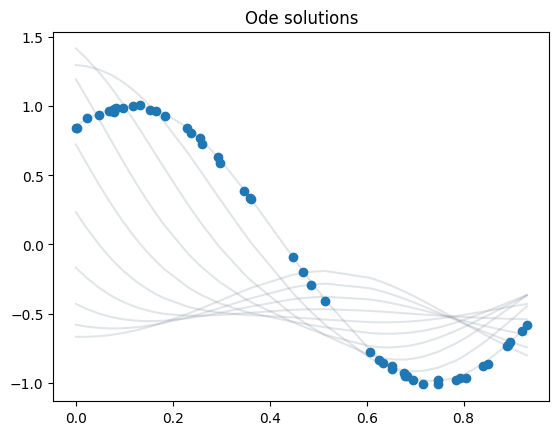

In [30]:
plt.plot(x_sorted, samples_sorted.transpose(), marker="None", linestyle="-", alpha=0.2, color="slategrey")
plt.plot(jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), label="Targets", linestyle="None", marker="o")
plt.title("Ode solutions")

### Multiple directions

In [31]:
idx = jnp.concatenate([jnp.arange(5), jnp.arange(15,20), jnp.arange(45,50)])
x_train = x_train[idx]
y_train = y_train[idx]

In [32]:
n_dirs = 50
random_init_dir = jax.random.normal(sample_key, (n_dirs, D,))

def non_ker_ode_solve_multiple_dir(single_dir):
    n_evals = 2
    integration_time = 1.0
    rank = 7
    v0 = jnp.ones(D)*5
    nonker_posterior, y_sols = ode_ggn(model,params,single_dir,v0,rank,n_evals,integration_time,x_train,"regression",1e-7, 1e-7,1.0,"non-kernel")
    nonker_posterior = jax.tree_map(lambda x: x[-1], nonker_posterior)
    return nonker_posterior
    
# nonker_posterior = jax.vmap(non_ker_ode_solve_multiple_dir)(random_init_dir)
nonker_posterior = jax.lax.map(non_ker_ode_solve_multiple_dir, random_init_dir)


In [33]:
nonker_predictive = sample_predictive(nonker_posterior, params, model, x_val, False, "Pytree")
x_sorted, idx = jnp.sort(x_val[:, 0]), jnp.argsort(x_val[:, 0])
nonker_samples_sorted = nonker_predictive[:, idx, :].squeeze()



In [34]:
n_dirs = 50
random_init_dir = jax.random.normal(sample_key, (n_dirs, D,))

def ker_ode_solve_multiple_dir(single_dir):
    n_evals = 2
    integration_time = 1.0
    rank = 7
    v0 = jnp.ones(D)*5
    ker_posterior, y_sols = ode_ggn(model,params,single_dir,v0,rank,n_evals,integration_time,x_train,"regression",1e-7, 1e-7,1.0,"kernel")
    ker_posterior = jax.tree_map(lambda x: x[-1], ker_posterior)
    return ker_posterior
    
# ker_posterior = jax.vmap(ker_ode_solve_multiple_dir)(random_init_dir)
ker_posterior = jax.lax.map(ker_ode_solve_multiple_dir, random_init_dir)


In [35]:
ker_predictive = sample_predictive(ker_posterior, params, model, x_val, False, "Pytree")
x_sorted, idx = jnp.sort(x_val[:, 0]), jnp.argsort(x_val[:, 0])
ker_samples_sorted = ker_predictive[:, idx, :].squeeze()


[]

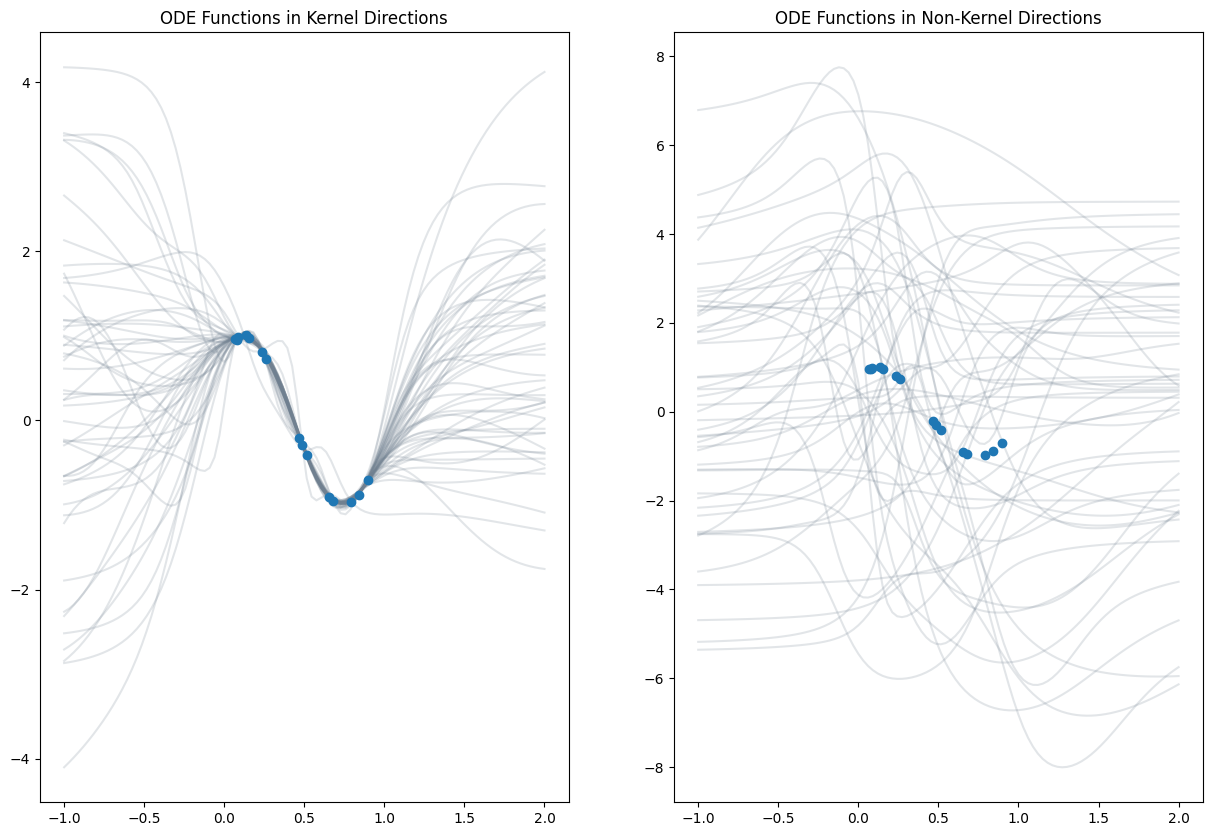

In [36]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 10))
ax[0].plot(x_sorted, ker_samples_sorted.transpose(), marker="None", linestyle="-", alpha=0.2, color="slategrey")
ax[0].plot(jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), label="Targets", linestyle="None", marker="o")
ax[0].set_title("ODE Functions in Kernel Directions")
ax[1].plot(x_sorted, nonker_samples_sorted.transpose(), marker="None", linestyle="-", alpha=0.2, color="slategrey")
ax[1].plot(jnp.array(x_train[:, 0]), jnp.array(y_train[:, 0]), label="Targets", linestyle="None", marker="o")
ax[1].set_title("ODE Functions in Non-Kernel Directions")
plt.plot()